In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from Motor_control_lib import Multimotor_control
from leap_hand_utils import *

In [2]:
# Functions
def Rot_z(theta):
    return sp.Matrix([[sp.cos(theta), -sp.sin(theta)], [sp.sin(theta), sp.cos(theta)]])

def cross_2d(v1, v2):
    return v1[0] * v2[1] - v1[1] * v2[0]

def Grasp_Matrix(theta, d):
    b1 = sp.Matrix([d, 0])
    b2 = sp.Matrix([-d, 0])
    R = Rot_z(theta)
    R1 = Rot_z(sp.pi/2 + theta)
    R2 = Rot_z(3*sp.pi/2 + theta)
    G1 = sp.Matrix.vstack(R1, sp.Matrix([[cross_2d(R * b1, R1.col(0)), cross_2d(R * b1, R1.col(1))]]))
    G2 = sp.Matrix.vstack(R2, sp.Matrix([[cross_2d(R * b2, R2.col(0)), cross_2d(R * b2, R2.col(1))]]))
    G = sp.Matrix.hstack(G1, G2)
    return G

def SCM_Jacobian_1(L, phi):
    # Calculate repeated expressions only once
    phi_01 = phi[0] + phi[1]
    phi_012 = phi_01 + phi[2]
    phi_0123 = phi_012 + phi[3]

    # Construct the Jacobian matrix using sympy.Matrix
    J = sp.Matrix([
        [-L[0] * sp.sin(phi[0]) - L[1] * sp.sin(phi_01) - L[2] * sp.sin(phi_012) - L[3] * sp.sin(phi_0123),
         -L[1] * sp.sin(phi_01) - L[2] * sp.sin(phi_012) - L[3] * sp.sin(phi_0123),
         -L[2] * sp.sin(phi_012) - L[3] * sp.sin(phi_0123),
         -L[3] * sp.sin(phi_0123)],

        [L[0] * sp.cos(phi[0]) + L[1] * sp.cos(phi_01) + L[2] * sp.cos(phi_012) + L[3] * sp.cos(phi_0123),
         L[1] * sp.cos(phi_01) + L[2] * sp.cos(phi_012) + L[3] * sp.cos(phi_0123),
         L[2] * sp.cos(phi_012) + L[3] * sp.cos(phi_0123),
         L[3] * sp.cos(phi_0123)]
    ])
    
    return J

def Hand_Jacobian(phi1, phi2, L1, L2, theta, shi1, shi2):
    RPK1, RPK2 = Rot_z(shi1), Rot_z(shi2)
    R1, R2 = Rot_z(sp.pi/2 + theta), Rot_z(3*sp.pi/2 + theta)
    J1, J2 = SCM_Jacobian_1(L1, phi1), SCM_Jacobian_1(L2, phi2)
    Jh = sp.Matrix.vstack(sp.Matrix.hstack(sp.transpose(R1) * RPK1 * J1, sp.zeros(2, 4)), sp.Matrix.hstack(sp.zeros(2, 4), sp.transpose(R2) * RPK2 * J2))
    return Jh

def trajectory_planner(to, tf, thetai, thetadi, thetaf, thetadf):
    t = sp.symbols('t')
    Q = np.array([thetai, thetadi, thetaf, thetadf])
    t0 = to
    B = np.array([
        [1, t0, t0**2, t0**3],
        [0, 1, 2*t0, 3*t0**2],
        [1, tf, tf**2, tf**3],
        [0, 1, 2*tf, 3*tf**2]
    ])
    Binv = np.linalg.inv(B)
    A = Binv @ Q
    a0, a1, a2, a3 = A
    
    theta_d = a0 + a1*t + a2*t**2 + a3*t**3
    thetadot_d = a1 + 2*a2*t + 3*a3*t**2
    thetaddot_d = 2*a2 + 6*a3*t

    return theta_d, thetadot_d, thetaddot_d

def animate_4R(phi, d, L1, L2, y):
    xi = phi
    l1, l2, l3, l4 = L1
    l11, l22, l33, l44 = L2
    
    fig, ax = plt.subplots()
    plt.ion()

    for i in range(0, len(phi[0]), 30):
        phi11, phi12, phi13, phi14 = xi[0:4, i]
        phi21, phi22, phi23, phi24 = xi[4:8, i]

        # First finger transformations
        H01 = transformation_matrix(l1, phi11)
        H12 = transformation_matrix(l2, phi12)
        H23 = transformation_matrix(l3, phi13)
        H34 = transformation_matrix(l4, phi14)
        
        H02 = H01 @ H12
        H03 = H02 @ H23
        H04 = H03 @ H34

        P1 = H01[0:2, 3] + d
        P2 = H02[0:2, 3] + d
        P3 = H03[0:2, 3] + d
        P4 = H04[0:2, 3] + d

        # Second finger transformations
        H01_2 = transformation_matrix(l11, phi21)
        H12_2 = transformation_matrix(l22, phi22)
        H23_2 = transformation_matrix(l33, phi23)
        H34_2 = transformation_matrix(l44, phi24)

        H02_2 = H01_2 @ H12_2
        H03_2 = H02_2 @ H23_2
        H04_2 = H03_2 @ H34_2

        P1_2 = H01_2[0:2, 3] - d
        P2_2 = H02_2[0:2, 3] - d
        P3_2 = H03_2[0:2, 3] - d
        P4_2 = H04_2[0:2, 3] - d

        ax.clear()
        plot_finger(ax, [0, P1[0]], [0, P1[1]], 'r')
        plot_finger(ax, [P1[0], P2[0]], [P1[1], P2[1]], 'r')
        plot_finger(ax, [P2[0], P3[0]], [P2[1], P3[1]], 'r')
        plot_finger(ax, [P3[0], P4[0]], [P3[1], P4[1]], 'r')

        plot_finger(ax, [0, P1_2[0]], [0, P1_2[1]], 'k')
        plot_finger(ax, [P1_2[0], P2_2[0]], [P1_2[1], P2_2[1]], 'k')
        plot_finger(ax, [P2_2[0], P3_2[0]], [P2_2[1], P3_2[1]], 'k')
        plot_finger(ax, [P3_2[0], P4_2[0]], [P3_2[1], P4_2[1]], 'k')

        circle = plt.Circle((0, y[i]), d, color='r', fill=True)
        ax.add_patch(circle)

        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
        ax.set_aspect('equal')
        ax.grid(True)
        
        plt.draw()
        plt.pause(0.1)

def transformation_matrix(l, phi):
    return np.array([
        [np.cos(phi), -np.sin(phi), 0, l * np.cos(phi)],
        [np.sin(phi), np.cos(phi), 0, l * np.sin(phi)],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def plot_finger(ax, x, y, color):
    ax.plot(x, y, color=color, linewidth=2)
    ax.plot(x[-1], y[-1], 'ok', linewidth=1)

def determinant_of_3x3(matrix):
    if matrix.shape != (3, 3):
        raise ValueError("The matrix must be 3x3")
    a, b, c = matrix.row(0)
    d, e, f = matrix.row(1)
    g, h, i = matrix.row(2)
    determinant = (a * (e * i - f * h) -
                   b * (d * i - f * g) +
                   c * (d * h - e * g))
    return determinant

def IK_2R_elbow_up(X, Y, l1, l2):
    d = np.sqrt(X**2 + Y**2)
    calpha = (l1**2 + l2**2 - d**2) / (2 * l1 * l2)
    salpha = np.sqrt(1 - calpha**2)
    alpha = np.arctan2(salpha, calpha)
    q2 = np.pi - alpha
    alp = np.arctan2(Y, X)
    beta = np.arctan2(l2 * np.sin(q2), l1 + l2 * np.cos(q2))
    q1 = alp - beta
    return q1, q2

def IK_2R_elbow_down(X, Y, l1, l2):
    d = np.sqrt(X**2 + Y**2)
    calpha = (l1**2 + l2**2 - d**2) / (2 * l1 * l2)
    salpha = np.sqrt(1 - calpha**2)
    alpha = np.arctan2(salpha, calpha)
    q2 = np.pi - alpha
    alp = np.arctan2(Y, X)
    calpha1 = (l1**2 + d**2 - l2**2) / (2 * l1 * d)
    salpha1 = np.sqrt(1 - calpha1**2)
    beta = np.arctan2(salpha1, calpha1)
    q1 = alp + beta
    q2 = -q2
    return q1, q2

def fwd_grasp_kinematics(phi,L1,L2,d):
    x_right = L1[0]*np.cos(phi[0]) + L1[1]*np.cos(phi[0]+phi[1]) + L1[2]*np.cos(phi[0]+phi[1]+phi[2]) + L1[3]*np.cos(phi[0]+phi[1]+phi[2]+phi[3]) + d
    y_right = L1[0]*np.sin(phi[0]) + L1[1]*np.sin(phi[0]+phi[1]) + L1[2]*np.sin(phi[0]+phi[1]+phi[2]) + L1[3]*np.sin(phi[0]+phi[1]+phi[2]+phi[3])
    x_left =  L2[0]*np.cos(phi[4]) + L2[1]*np.cos(phi[4]+phi[5]) + L2[2]*np.cos(phi[4]+phi[5]+phi[6]) + L2[3]*np.cos(phi[4]+phi[5]+phi[6]+phi[7]) - d
    y_left =  L2[0]*np.sin(phi[4]) + L2[1]*np.sin(phi[4]+phi[5]) + L2[2]*np.sin(phi[4]+phi[5]+phi[6]) + L2[3]*np.sin(phi[4]+phi[5]+phi[6]+phi[7]) 
    x = (x_right + x_left)/2
    y = (y_right + y_left)/2
    theta = (y_right-y_left)/(x_right-x_left)
    return x,y,theta

def d_actual(phi,L1,L2,d):
    x_right = L1[0]*np.cos(phi[0]) + L1[1]*np.cos(phi[0]+phi[1]) + L1[2]*np.cos(phi[0]+phi[1]+phi[2]) + L1[3]*np.cos(phi[0]+phi[1]+phi[2]+phi[3]) + d
    y_right = L1[0]*np.sin(phi[0]) + L1[1]*np.sin(phi[0]+phi[1]) + L1[2]*np.sin(phi[0]+phi[1]+phi[2]) + L1[3]*np.sin(phi[0]+phi[1]+phi[2]+phi[3])
    x_left =  L2[0]*np.cos(phi[4]) + L2[1]*np.cos(phi[4]+phi[5]) + L2[2]*np.cos(phi[4]+phi[5]+phi[6]) + L2[3]*np.cos(phi[4]+phi[5]+phi[6]+phi[7]) - d
    y_left =  L2[0]*np.sin(phi[4]) + L2[1]*np.sin(phi[4]+phi[5]) + L2[2]*np.sin(phi[4]+phi[5]+phi[6]) + L2[3]*np.sin(phi[4]+phi[5]+phi[6]+phi[7]) 
    d_actual = np.sqrt((x_right-x_left)**2 + (y_right-y_left)**2)
    return d_actual

def custom_inverse_3x3(M):
    det = M.det()
    if det == 0:
        raise ValueError("Matrix is singular and cannot be inverted.")
    
    adjoint = sp.Matrix([
        [M[1,1]*M[2,2] - M[1,2]*M[2,1], M[0,2]*M[2,1] - M[0,1]*M[2,2], M[0,1]*M[1,2] - M[0,2]*M[1,1]],
        [M[1,2]*M[2,0] - M[1,0]*M[2,2], M[0,0]*M[2,2] - M[0,2]*M[2,0], M[0,2]*M[1,0] - M[0,0]*M[1,2]],
        [M[1,0]*M[2,1] - M[1,1]*M[2,0], M[0,1]*M[2,0] - M[0,0]*M[2,1], M[0,0]*M[1,1] - M[0,1]*M[1,0]]
    ])
    
    inv_M = adjoint / det
    return inv_M

In [3]:
phi11, phi12, phi13, phi14 = sp.symbols('phi11 phi12 phi13 phi14', real=True)
l11, l12, l13, l14 = sp.symbols('l11 l12 l13 l14', real=True)
L= sp.Matrix([l11,l12,l13,l14])
phi = sp.Matrix([phi11,phi12,phi13,phi14])
J=SCM_Jacobian_1(L,phi)
print(J[0,3])

-l14*sin(phi11 + phi12 + phi13 + phi14)


In [5]:
# Cost function preparation
phi11, phi12, phi13, phi14 = sp.symbols('phi11 phi12 phi13 phi14', real=True)
phi21, phi22, phi23, phi24 = sp.symbols('phi21 phi22 phi23 phi24', real=True)
theta, d, shi1, shi2 = sp.symbols('theta d shi1 shi2', real=True)
l11, l12, l13, l14 = sp.symbols('l11 l12 l13 l14', real=True)
l21, l22, l23, l24 = sp.symbols('l21 l22 l23 l24', real=True)
Fx, Fy, Fz = sp.symbols('Fx Fy Fz', real=True)

phi1 = sp.Matrix([phi11, phi12, phi13, phi14])
phi2 = sp.Matrix([phi21, phi22, phi23, phi24])
L1 = sp.Matrix([l11, l12, l13, l14])
L2 = sp.Matrix([l21, l22, l23, l24])

x_right = l11*sp.cos(phi11) + l12*sp.cos(phi11+phi12) + l13*sp.cos(phi11+phi12+phi13) + l14*sp.cos(phi11+phi12+phi13+phi14) + d
y_right = l11*sp.sin(phi11) + l12*sp.sin(phi11+phi12) + l13*sp.sin(phi11+phi12+phi13) + l14*sp.sin(phi11+phi12+phi13+phi14)
x_left =  l21*sp.cos(phi21) + l22*sp.cos(phi21+phi22) + l23*sp.cos(phi21+phi22+phi23) + l24*sp.cos(phi21+phi22+phi23+phi24) - d
y_left =  l21*sp.sin(phi21) + l22*sp.sin(phi21+phi22) + l23*sp.sin(phi21+phi22+phi23) + l24*sp.sin(phi21+phi22+phi23+phi24) 

d_current = sp.sqrt((x_right-x_left)**2 + (y_right-y_left)**2)

G = Grasp_Matrix(theta, d)
Jh = Hand_Jacobian(phi1, phi2, L1, L2, theta, shi1, shi2)
Gt =  G.transpose()
Gtinv= Gt.pinv()
A=Gtinv*Jh
dia = 2*d
# W = (1/(determinant_of_3x3((A * A.T)))) + (1/((d_current-(2*d))**gm2))
# W = ((d_current-(dia))**2) + (determinant_of_3x3((A * A.T)))
W1 = (determinant_of_3x3((A * A.T))) # Velocity manipulability
W2 = 1/(determinant_of_3x3(A * A.T)) # Force manipulability
phio = sp.Matrix([W1.diff(p) for p in [phi11, phi12, phi13, phi14, phi21, phi22, phi23, phi24]])
# Convert symbolic expressions to numerical functions using lambdify
grad = sp.lambdify((phi11, phi12, phi13, phi14, phi21, phi22, phi23, phi24, theta, d, shi1, shi2, l11, l12, l13, l14, l21, l22, l23, l24), phio, 'numpy')

# Directional force manipulability
# G1 = G[:2,:] 
# Gt1 = G1.transpose()
# Gt1inv = Gt1.pinv()
# A1 = Gt1inv*Jh
# F = sp.diag(Fx,Fy)
# AA = (((A1*A1.T)/(A1*A1.T).trace()) - (F/F.trace()))
# W3 = sp.sqrt((AA*AA.T).trace())
# phio1 = sp.Matrix([W3.diff(p) for p in [phi11, phi12, phi13, phi14, phi21, phi22, phi23, phi24]])
# grad = sp.lambdify((phi11, phi12, phi13, phi14, phi21, phi22, phi23, phi24, theta, d, shi1, shi2, l11, l12, l13, l14, l21, l22, l23, l24, Fx, Fy), phio1, 'numpy')


In [6]:
# Main code -- Initialization and trajectory planning
dt = 1e-2
to = 0
tf = 10
timerx = np.arange(to, tf + dt, dt)

# Link lengths
l11 = l12 = l13 = 55
l21 = l22 = l23 = 55
l14 = 35
l24 = 35
L1 = [l11, l12, l13, l14]
L2 = [l21, l22, l23, l24]

# Perform trajectory planning
yd, ydotd, yddotd = trajectory_planner(to, tf, 100, 0, 150, 0)
th, thd, thdd = trajectory_planner(to, tf, 0, 0, 0, 0)

# Evaluate trajectories over time
y = np.array([float(yd.subs('t', t)) for t in timerx])
y_d = np.array([float(ydotd.subs('t', t)) for t in timerx])
theta = np.array([float(th.subs('t', t)) for t in timerx])
thetad = np.array([float(thd.subs('t', t)) for t in timerx])


In [8]:
# Main code -- Kinematic Redundancy Optimisation
# Calculate initial joint angles
q11, q12 = IK_2R_elbow_up(-45, 100, l11+l12, l13+l14)
q21, q22 = IK_2R_elbow_down(45, 100, l21+l22, l23+l24)

# Define phi for both systems
phi1 = [q11, 0, q12, 0]
phi2 = [q21, 0, q22, 0]
phi = phi1 + phi2

# Define constants
d = 70 # Radius of the ball
shi1 = 0
shi2 = 0
fx = 2
fy = 2
# Kp = np.array([[1,0,0],[0,1,0],[0,0,1]])
Kp = np.eye(3)*10

# Initialize phi arrays based on earlier values of phi1 and phi2
w_cost = np.zeros(len(timerx))
A_list = []
d_act = np.zeros(len(timerx))
d_desired = np.zeros(len(timerx))
phi = np.zeros((8, len(timerx) + 1))
phi[0:4, 0] = phi1
phi[4:8, 0] = phi2

for i in range(len(timerx)):
    # print(i)
    qdot = np.array([0, y_d[i], thetad[i]])
    q = np.array([0,y[i],theta[i]])
    G = np.array(Grasp_Matrix(theta[i], d), dtype=np.float64)
    Jh = np.array(Hand_Jacobian(phi[0:4, i], phi[4:8, i], L1, L2, theta[i], shi1, shi2), dtype=np.float64)
    A = np.linalg.pinv(np.transpose(G)) @ Jh 
    B = np.linalg.pinv(Jh) @ np.transpose(G)

    A_list.append(A)
    # Null Space calculation
    gain = 0.00000001
    # Null space contribution for manipulability
    no =(grad(phi[0, i], phi[1, i], phi[2, i], phi[3, i], phi[4, i], phi[5, i], phi[6, i], phi[7, i], theta[i], d, shi1, shi2, L1[0], L1[1], L1[2], L1[3], L2[0], L2[1], L2[2], L2[3]))*gain
    

    # Null space contribution for directional force manipulability
    # gain_dc = 10
    # no =(grad(phi[0, i], phi[1, i], phi[2, i], phi[3, i], phi[4, i], phi[5, i], phi[6, i], phi[7, i], theta[i], d, shi1, shi2, L1[0], L1[1], L1[2], L1[3], L2[0], L2[1], L2[2], L2[3], fx , fy))*gain_dc
    
    # NC = (np.eye(8) - B @ np.linalg.pinv(B)) @ no
    NC = (np.eye(8) - np.linalg.pinv(Jh) @ Jh) @ no
    
    Gain_NC = np.eye(8)  # Assuming a gain of 1 for simplicity

    # Update phi
    q_current = fwd_grasp_kinematics(phi[:, i],L1,L2,d)
    err = q - q_current
    
    phi[:, i + 1] = phi[:, i] + (B @ (qdot + (Kp @ err)) * dt).flatten() + (Gain_NC @ NC * dt).flatten()
    w_cost[i] = np.sqrt(np.linalg.det((A @ A.T)))
    d_act[i] = d_actual(phi[:, i],L1,L2,d)
    d_desired[i] =2*d
    # print((B @ Kp @ err)*dt)
    # print(Gain_NC @ NC*dt)
# Split phi back into phi1 and phi2
phi1 = phi[0:4, :]
phi2 = phi[4:8, :]
np.save("phi_matrix.npy", phi)
np.save("Y_traj.npy",y)
A_array = np.array(A_list)
np.save("A_matrix",A_array)

In [18]:
# Experimental Implementation
kP = 600   # Set Kp of motors
kI = 0     # Set Ki of motors
kD = 200   # Set Kd of motors
curr_lim = 350 # Set maximum current limit

motor_ID = [11, 12, 13, 14]
Two_finger_robot = Multimotor_control(IDs = motor_ID)
Two_finger_robot.set_operating_mode(motor_ID,np.ones(len(motor_ID)) *3)

Two_finger_robot.torque_activate(motor_ID)

Two_finger_robot.set_motor_propotional_gain(motor_ID,np.ones(len(motor_ID)) * kP)   
Two_finger_robot.set_motor_derivative_gain(motor_ID,np.ones(len(motor_ID)) * kD) 
Two_finger_robot.set_motor_integrator_gain(motor_ID,np.ones(len(motor_ID)) * kI)
Two_finger_robot.set_motor_max_current(motor_ID,np.ones(len(motor_ID)) * curr_lim)

Two_finger_robot.set_goal_position(phi1[:,0],motor_ID)



Trying to connect to /dev/ttyUSB0
Failed to connect to /dev/ttyUSB0: could not open port '/dev/ttyUSB0': FileNotFoundError(2, 'The system cannot find the path specified.', None, 3)
Trying to connect to /dev/ttyUSB1
Failed to connect to /dev/ttyUSB1: could not open port '/dev/ttyUSB1': FileNotFoundError(2, 'The system cannot find the path specified.', None, 3)
Trying to connect to COM13
Failed to connect to COM13: could not open port 'COM13': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)


Exception: Could not connect to any of the specified ports

In [9]:
# np.save('w_with_red',w_cost)
np.save('w_cost_without_red',w_cost)

Text(0, 0.5, 'Manipulability')

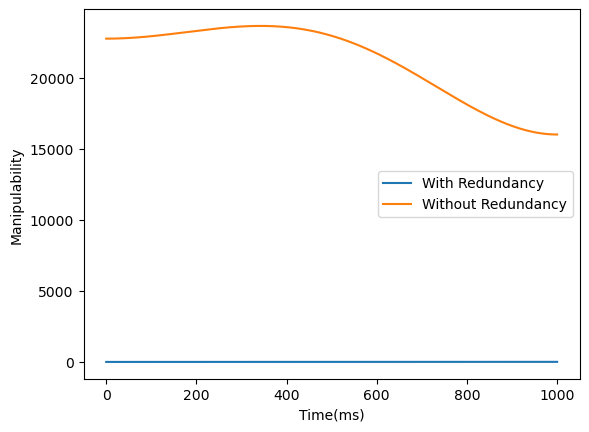

In [17]:
w_without_red=np.load('w_cost_without_red.npy')
w_with_red=np.load('w_with_red.npy')
plt.plot(w_with_red)
plt.plot(w_without_red)
plt.legend(['With Redundancy', 'Without Redundancy'])
plt.xlabel('Time(ms)')
plt.ylabel('Manipulability')

(0.5, 5.0)

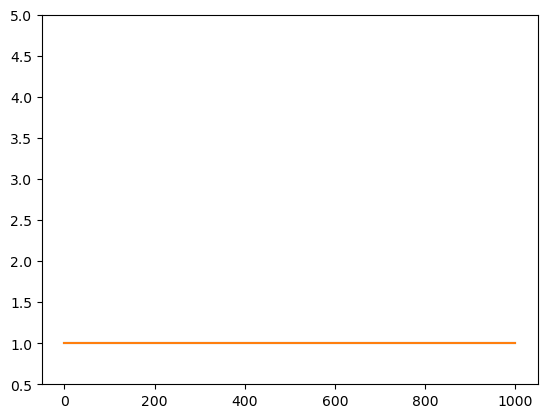

In [9]:
plt.plot(d_act)
plt.plot(d_desired)
plt.ylim([0.5,5])

In [10]:
# numerical_result = grad(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)
# print(numerical_result)

In [11]:
# [ang1,ang2] = IK_2R_elbow_up(0,0.6,1,1)
# x_cord = 1*np.cos(ang1) + 1*np.cos(ang1+ang2)
# y_cord = 1*np.sin(ang1) + 1*np.sin(ang1+ang2)
# print(x_cord,y_cord)